# 🌿Plant Pathology 2020 - Yaprak Hastalıkları Sınıflandırma
Proje: Kaggle Deep Learning Bootcamp için hazırlanmıştır. Veri: Plant Pathology 2020 (Kaggle competition) 

Amaç: Yaprak resimlerini 4 sınıfa ayıran bir CNN + Transfer Learning modeli oluşturmak.

## 📦 Gerekli Kütüphanelerin Yüklenmesi

Bu hücrede proje için kullanılan tüm kütüphaneler içe aktarılmıştır:

- **os** → Dosya ve klasör işlemleri için.  
- **numpy, pandas** → Sayısal işlemler ve veri analizi için.  
- **matplotlib, seaborn** → Veri görselleştirme ve grafik çizimleri için.  
- **scikit-learn (train_test_split, classification_report, confusion_matrix)** → Veri setini bölme ve sınıflandırma performans ölçümleri için.  
- **tensorflow.keras** → Derin öğrenme modeli oluşturma, eğitim ve değerlendirme için.  
  - **ImageDataGenerator**: Görüntü ön işleme ve veri artırma (data augmentation).  
  - **layers, models**: CNN mimarisini oluşturma.  
  - **EarlyStopping, ReduceLROnPlateau**: Eğitim sürecinde optimizasyon için callback’ler.  
  - **EfficientNetB0**: Transfer learning için kullanılan önceden eğitilmiş güçlü bir CNN mimarisi.  

Bu kütüphaneler ile proje boyunca veri işlenecek, model kurulacak, eğitilecek ve sonuçlar görselleştirilecektir.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0

## 📂 Veri Setinin Kontrol Edilmesi

Bu hücrede, **Plant Pathology 2020** veri seti Kaggle ortamına eklenmiş ve dosyaların varlığı kontrol edilmiştir.  

- `base_path` değişkeni ile veri setinin yolu tanımlanmıştır.  
  - Kaggle üzerinde "Add Data" seçeneği ile eklenen veri setinin doğru yolunun kopyalanması önemlidir.  
- `os.listdir()` komutu ile klasör içerisindeki dosyalar listelenmiştir.  
- **train.csv** dosyası okunarak bir `pandas DataFrame` içerisine aktarılmıştır.  
- `df.shape` ile veri setinin boyutu görüntülenmiş, `df.head()` ile de ilk birkaç satır incelenmiştir.  

Bu adım, veri setinin doğru yüklendiğini doğrulamak ve yapısını incelemek için yapılmaktadır.

In [3]:
base_path = "/kaggle/input/plant-pathology-2020-fgvc7"   

print("Dosyalar:", os.listdir(base_path)[:20])
csv_file = os.path.join(base_path, "train.csv")
df = pd.read_csv(csv_file)
print(df.shape)
df.head()

Dosyalar: ['sample_submission.csv', 'images', 'train.csv', 'test.csv']
(1821, 5)


,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


## 🏷️ Etiketlerin Hazırlanması ve Örnek Görseller
Bu hücrede veri setindeki etiket (label) sütunu hazırlanmış ve sınıf dağılımları incelenmiştir:

- train.csv dosyasında genellikle etiketler **one-hot** formatındadır:

  - `healthy`
  - `multiple_diseases`
  - `rust`
  - `scab`

- Eğer `label` sütunu yoksa, bu one-hot sütunlardan yeni bir **label sütunu** türetilmiştir.
- Bazı alternatif veri setlerinde `labels` veya `category` sütunları olabileceğinden, bu sütunlar da `label` olarak yeniden adlandırılmıştır.
- `image_id` sütununa `.jpg` uzantısı eklenerek dosya adları hazırlanmıştır.

Ardından:

- `value_counts()` ile sınıfların dağılımı ekrana yazdırılmıştır.
- Veri setinden **rastgele 6 görsel** seçilmiş ve ilgili sınıf etiketi ile birlikte görselleştirilmiştir.

Bu adım sayesinde hem etiketler doğru formatta elde edilmiş, hem de veri setinden örnek görüntüler görselleştirilerek model eğitimi öncesi doğrulama yapılmıştır.

Sınıf dağılımı:


label
rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: count, dtype: int64

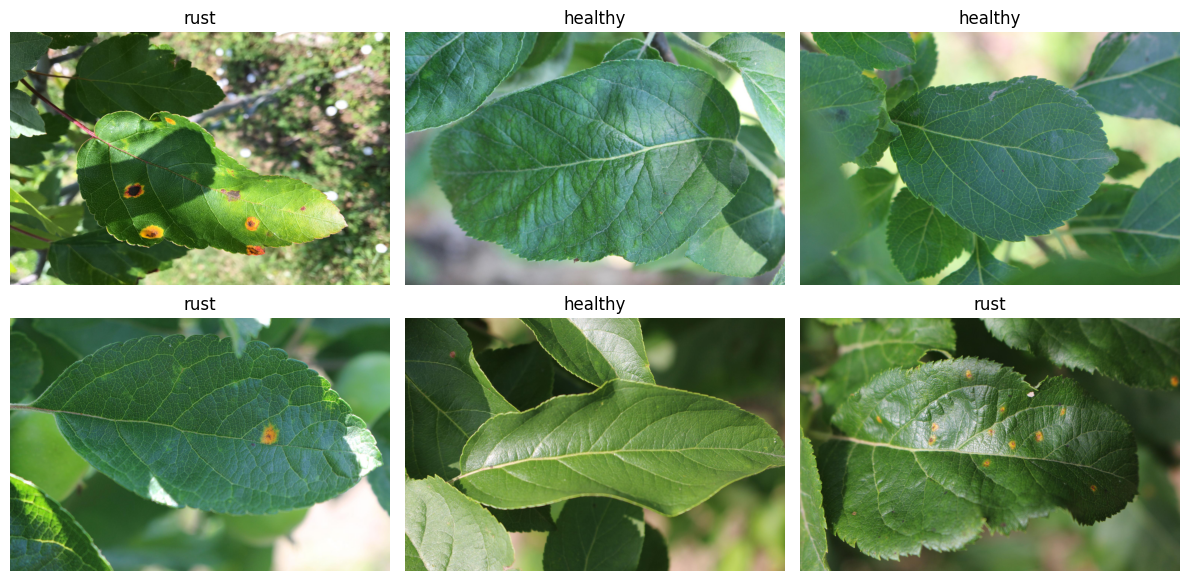

In [4]:
if 'label' not in df.columns:
    possible = {'healthy','multiple_diseases','rust','scab'}
    if possible.issubset(set(df.columns)):
        def make_label(row):
            for c in ['healthy','multiple_diseases','rust','scab']:
                if row[c] == 1:
                    return c
        df['label'] = df.apply(make_label, axis=1)
    elif 'labels' in df.columns or 'category' in df.columns:
        # farklı format varsa:
        df.rename(columns={'labels':'label','category':'label'}, inplace=True)

df['image_id'] = df['image_id'].astype(str) + ".jpg"
print("Sınıf dağılımı:")
display(df['label'].value_counts())

# Örnek görseller
sample = df.sample(6, random_state=42)
plt.figure(figsize=(12,6))
for i, row in enumerate(sample.itertuples()):
    plt.subplot(2,3,i+1)
    img = mpimg.imread(os.path.join(base_path, "images", row.image_id))
    plt.imshow(img)
    plt.title(row.label)
    plt.axis('off')
plt.tight_layout()

## 🔄 Veri Bölme, Görüntü Ön İşleme ve Generator Hazırlığı

Bu hücrede veri seti eğitim/doğrulama olarak ayrılmış ve modelin beslenebilmesi için jeneratörler oluşturulmuştur:

1. **Veri Bölme**
   - `train_test_split` fonksiyonu ile veriler **%80 eğitim** ve **%20 doğrulama** olacak şekilde ayrılmıştır.  
   - `stratify=df['label']` parametresi ile her sınıfın orantılı şekilde bölünmesi sağlanmıştır.  
   - Eğitim ve doğrulama veri setlerinin boyutları ekrana yazdırılmıştır.

2. **ImageDataGenerator ile Ön İşleme**
   - **Eğitim verileri (train_datagen)** üzerinde veri artırma (data augmentation) uygulanmıştır:  
     - Döndürme (`rotation_range=25`)  
     - Yatay kaydırma (`width_shift_range=0.1`)  
     - Dikey kaydırma (`height_shift_range=0.1`)  
     - Yakınlaştırma (`zoom_range=0.2`)  
     - Yatay çevirme (`horizontal_flip=True`)  
     - Normalizasyon (`rescale=1./255`)  
   - **Doğrulama verileri (val_datagen)** üzerinde yalnızca normalizasyon uygulanmıştır.

3. **flow_from_dataframe Kullanımı**
   - Görsellerin yolu (`x_col="image_id"`) ve etiket sütunu (`y_col="label"`) belirtilerek eğitim ve doğrulama jeneratörleri hazırlanmıştır.  
   - `target_size=(224,224)` parametresi ile görseller modelin giriş boyutuna uygun hale getirilmiştir.  
   - Eğitimde shuffle=True, doğrulamada shuffle=False kullanılmıştır.  

4. **Sınıf İndeksleri**
   - `class_indices` çıktısı ile her bir sınıfın hangi index numarasına karşılık geldiği ekrana yazdırılmıştır.

In [5]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
print(train_df.shape, val_df.shape)

# Augmentation & generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=25,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, directory=os.path.join(base_path, "images"),
    x_col="image_id", y_col="label",
    target_size=(224,224), class_mode="categorical", batch_size=32, shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, directory=os.path.join(base_path, "images"),
    x_col="image_id", y_col="label",
    target_size=(224,224), class_mode="categorical", batch_size=32, shuffle=False
)

class_indices = train_gen.class_indices
print("Sınıf indeksi:",class_indices)

(1456, 6) (365, 6)
Found 1456 validated image filenames belonging to 4 classes.
Found 365 validated image filenames belonging to 4 classes.
Sınıf indeksi: {'healthy': 0, 'multiple_diseases': 1, 'rust': 2, 'scab': 3}


## 🧠 Derin Öğrenme Modelinin Kurulması

Bu hücrede bitki yaprak hastalıklarını sınıflandırmak için bir **Convolutional Neural Network (CNN)** modeli oluşturulmuştur.  
Model **Keras Functional API** kullanılarak tanımlanmıştır.  

**Model Katmanları:**
- **Input Layer**: (224,224,3) boyutunda RGB görüntüleri giriş olarak alır.  
- **Conv2D + MaxPooling Katmanları**:  
  - İlk blok: 32 filtre, ardından 2x2 havuzlama  
  - İkinci blok: 64 filtre, ardından 2x2 havuzlama  
  - Üçüncü blok: 128 filtre, ardından 2x2 havuzlama  
- **Flatten**: Çok boyutlu özellik haritaları tek boyuta indirgenmiştir.  
- **Dense (128 nöron, ReLU)**: Tam bağlı katman eklenmiştir.  
- **Dropout (0.5)**: Aşırı öğrenmeyi (overfitting) önlemek için %50 nöron rastgele kapatılmıştır.  
- **Output Layer**: Sınıf sayısı kadar nöron, `softmax` aktivasyonu ile çok sınıflı sınıflandırma yapar.  

**Derleme (Compile) aşaması:**
- **Optimizer**: Adam  
- **Loss**: Categorical Crossentropy (çok sınıflı sınıflandırma için)  
- **Metric**: Accuracy  

Son olarak `model.summary()` fonksiyonu ile modelin katman yapısı ve parametre sayıları görüntülenmiştir.


In [7]:
from tensorflow.keras import layers, models
import tensorflow as tf

inputs = tf.keras.Input(shape=(224,224,3))
x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Conv2D(128, (3,3), activation='relu')(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_indices), activation='softmax')(x)

model = models.Model(inputs, outputs)   
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

## 📈 Modelin Eğitilmesi

Bu hücrede oluşturulan CNN modeli eğitim verileri üzerinde eğitilmiş ve doğrulama verileri ile performansı ölçülmüştür.  

- **train_gen** → Eğitim verilerini sağlar.  
- **val_gen** → Doğrulama verilerini sağlar.  
- **epochs=5** → İlk deneme için kısa eğitim süresi belirlenmiştir. Eğitim süresi doğrulama sonuçlarına göre artırılabilir (örneğin 15–20 epoch).  

Eğitim süresince her epoch sonunda:  
- Eğitim doğruluğu (accuracy)  
- Eğitim kaybı (loss)  
- Doğrulama doğruluğu (val_accuracy)  
- Doğrulama kaybı (val_loss)  

değerleri kaydedilmiştir.  
Bu sonuçlar **history** değişkeninde tutulmakta ve bir sonraki hücrede görselleştirilecektir.


In [9]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30   
)

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.3087 - loss: 1.9289 - val_accuracy: 0.3425 - val_loss: 1.2467
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 780ms/step - accuracy: 0.3490 - loss: 1.2452 - val_accuracy: 0.3260 - val_loss: 1.2593
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 35s 754ms/step - accuracy: 0.3441 - loss: 1.2574 - val_accuracy: 0.3616 - val_loss: 1.2539
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 35s 758ms/step - accuracy: 0.3404 - loss: 1.2710 - val_accuracy: 0.3507 - val_loss: 1.2318
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 773ms/step - accuracy: 0.3431 - loss: 1.2544 - val_accuracy: 0.3863 - val_loss: 1.2260
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 781ms/step - accuracy: 0.3566 - loss: 1.2392 - val_accuracy: 0.4137 - val_loss: 1.1829
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 789ms/step - accuracy: 0.3979 - loss: 1.2283 - val_accuracy: 0.4630 - val_loss: 1.2051
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 779ms/step - accuracy: 0.4180 - loss: 1.2268 - val_accurac

## 📊 Eğitim Sonuçlarının Görselleştirilmesi ve Değerlendirme

Bu hücrede modelin eğitim sürecindeki performansı grafikler ve metriklerle incelenmiştir:  

1. **Accuracy Grafiği**  
   - Eğitim (`train_acc`) ve doğrulama (`val_acc`) doğruluk değerleri çizdirilmiştir.  
   - Modelin zamanla doğruluk artışı gözlemlenmiştir.  

2. **Loss Grafiği**  
   - Eğitim (`train_loss`) ve doğrulama (`val_loss`) kayıp değerleri çizdirilmiştir.  
   - Kaybın azalması, modelin öğrenme sürecini göstermektedir.  

3. **Confusion Matrix (Karmaşıklık Matrisi)**  
   - Gerçek etiketler (`y_true`) ile modelin tahminleri (`y_pred`) karşılaştırılmıştır.  
   - Matriste her hücre, ilgili sınıfın doğru/yanlış tahmin sayılarını göstermektedir.  
   - Modelin hangi sınıfları doğru, hangilerini karıştırdığını gözlemlemek için kullanılmıştır.  

4. **Classification Report (Sınıflandırma Raporu)**  
   - Precision, Recall ve F1-score metrikleri her sınıf için hesaplanmıştır.  
   - Modelin sınıf bazlı performansı detaylı olarak analiz edilmiştir.  
   - `zero_division=0` parametresi sıfıra bölme hatalarını engellemek için kullanılmıştır.  

Bu adım sayesinde modelin başarımı hem genel hem de sınıf bazlı olarak değerlendirilmiştir.


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 359ms/step


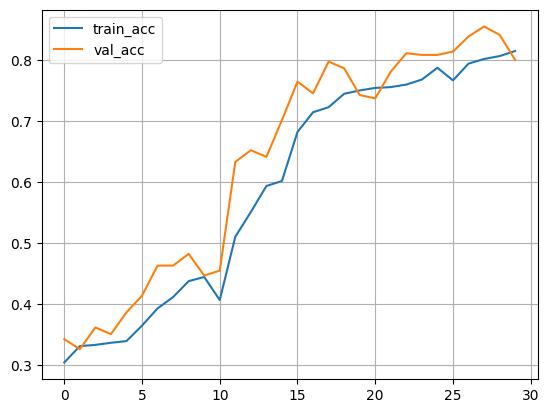

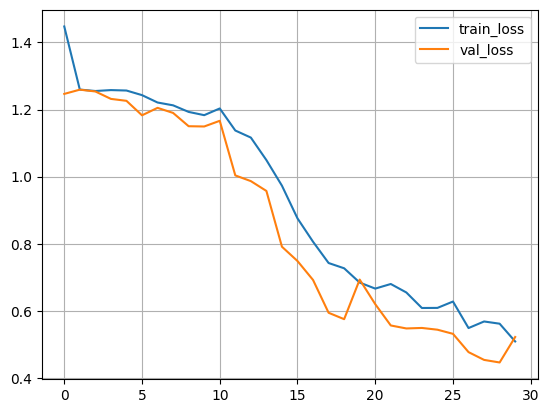

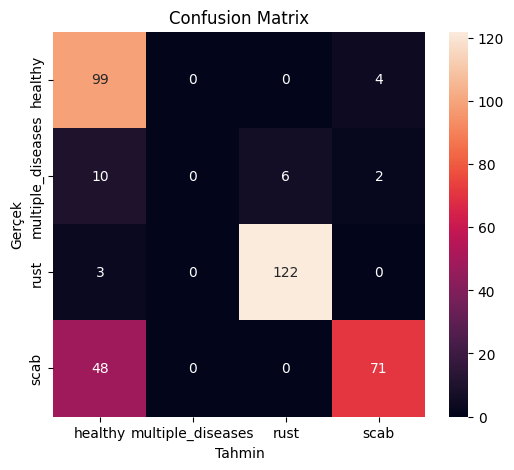

                   precision    recall  f1-score   support

          healthy       0.62      0.96      0.75       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.95      0.98      0.96       125
             scab       0.92      0.60      0.72       119

         accuracy                           0.80       365
        macro avg       0.62      0.63      0.61       365
     weighted avg       0.80      0.80      0.78       365



In [10]:
plt.figure(); plt.plot(history.history['accuracy'], label='train_acc'); plt.plot(history.history['val_accuracy'], label='val_acc'); plt.legend(); plt.grid();
plt.figure(); plt.plot(history.history['loss'], label='train_loss'); plt.plot(history.history['val_loss'], label='val_loss'); plt.legend(); plt.grid();

# Confusion matrix
val_preds = model.predict(val_gen)
y_true = val_gen.classes
y_pred = np.argmax(val_preds, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(class_indices.keys()), yticklabels=list(class_indices.keys()))
plt.xlabel('Tahmin'); plt.ylabel('Gerçek'); plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=list(class_indices.keys()), zero_division=0))

## 🔥 Grad-CAM ile Modelin Görselleştirilmesi

Bu hücrede **Grad-CAM (Gradient-weighted Class Activation Mapping)** yöntemi kullanılarak modelin karar mekanizması görselleştirilmiştir.  

**Adımlar:**
1. **Son Conv2D Katmanının Bulunması**  
   - Grad-CAM, modelin son konvolüsyon katmanındaki aktivasyon haritalarını kullanır.  
   - Son `Conv2D` katmanı belirlenmiş ve bu katmanın çıktısı alınmıştır.  

2. **Gradient Hesaplama**  
   - `GradientTape` ile tahmin edilen sınıfın loss değeri üzerinden son konvolüsyon katmanına göre gradyanlar hesaplanmıştır.  
   - Bu gradyanların ortalaması alınarak her filtre için önem (ağırlık) belirlenmiştir.  

3. **Isı Haritası (Heatmap) Oluşturma**  
   - Filtre aktivasyonları, hesaplanan gradyan ağırlıkları ile çarpılarak bir ısı haritası oluşturulmuştur.  
   - Değerler normalize edilip [0-1] aralığına getirilmiştir.  

4. **Orijinal Görüntü ile Birleştirme**  
   - Heatmap, orijinal resmin üzerine bindirilmiş ve hangi bölgelerin modelin tahminine daha fazla katkı sağladığı görselleştirilmiştir.  

**Sonuç:**  
- Sol tarafta orijinal yaprak görseli,  
- Sağ tarafta ise modelin tahmininde odaklandığı bölgeleri gösteren **Grad-CAM haritası** yer almaktadır.  

Bu yöntem, modelin “neden bu tahmini yaptığı” hakkında yorum yapılabilmesini sağlar ve açıklanabilir yapay zekâ (Explainable AI) açısından büyük önem taşır.


Kullanılan son conv layer: conv2d_5


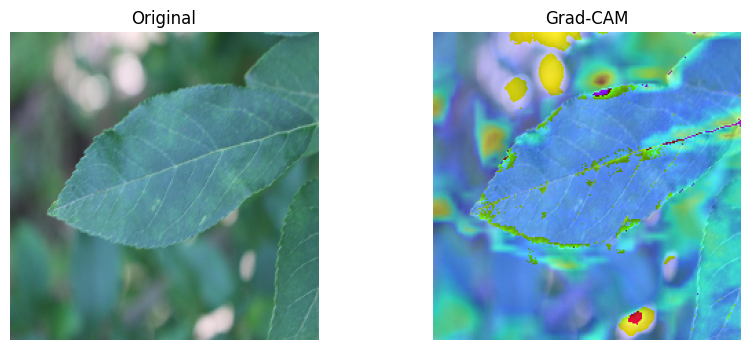

In [11]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

def make_gradcam_heatmap(img_array, model):
    # Son Conv2D katmanını bul
    conv_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            conv_layer = layer
            break

    # Grad-CAM modeli: son conv + output
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        pred_output = predictions[:, pred_index]

    grads = tape.gradient(pred_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy(), conv_layer.name



img_path = os.path.join(base_path, "images", val_df.sample(1).iloc[0]['image_id'])
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
img_array = tf.keras.preprocessing.image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

heatmap, used_layer = make_gradcam_heatmap(img_array, model)
print("Kullanılan son conv layer:", used_layer)

# Orijinal resim
img_orig = cv2.imread(img_path)
img_orig = cv2.resize(img_orig, (224,224))

# Heatmap üstüne bindir
heatmap = cv2.resize(heatmap, (224,224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img_orig


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('Original'); plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(superimposed_img.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title('Grad-CAM'); plt.axis('off')

plt.show()

## 💾 Modelin Kaydedilmesi ve Accuracy Grafiği

Bu hücrede eğitim tamamlandıktan sonra model .h5 formatında kaydedilmiştir.  
Kaydedilen model dosyası daha sonra yüklenip yeniden kullanılabilir, böylece tekrar eğitim yapılmasına gerek kalmaz.

- *model.save("plant_disease_model.h5")* → Eğitilen modeli plant_disease_model.h5 dosyası olarak kaydeder.  
- Kaydın başarılı olduğuna dair bir çıktı alınır.

Ayrıca, eğitim sürecindeki *doğruluk (accuracy)* metrikleri epoch bazında çizdirilmiştir.  
Grafikte:  
- Train Acc → Eğitim doğruluğu  
- Val Acc → Doğrulama doğruluğu  

görülmektedir.  
Bu grafik, modelin overfitting (aşırı öğrenme) yapıp yapmadığını veya doğrulama performansının artıp artmadığını gözlemlemek için oldukça faydalıdır.

 Model başarıyla kaydedildi: plant_disease_model.h5


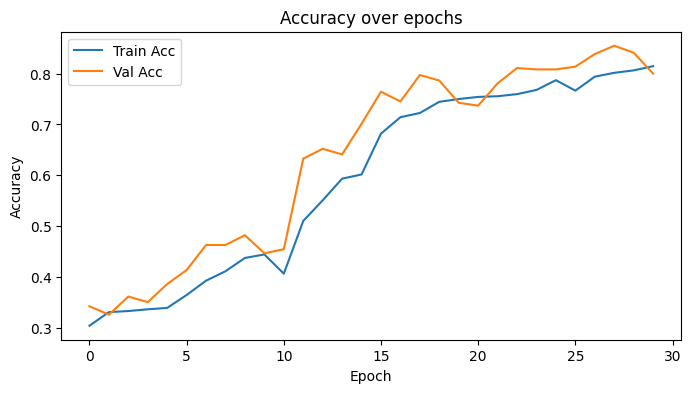

In [13]:
# Modeli kaydet
model.save("plant_disease_model.h5")
print(" Model başarıyla kaydedildi: plant_disease_model.h5")

# Eğitim eğrilerini çizdir
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over epochs")
plt.show()